In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import random
import urllib
import cv2

from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from tensorflow.keras import layers

from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LeakyReLU

import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil

import matplotlib.pyplot as plt
import numpy as np
import itertools

from keras.layers import Lambda

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/My Drive/Colab Notebooks/erg8_patern_recognition_2021/Dataset"

In [5]:
img_height = 100
img_width  = 100
classes    = ['0','1','2','3','4','5','6','7','8','9']
batch_size = 150

In [6]:
tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.2
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale"
  )

Found 2059 files belonging to 10 classes.
Using 1442 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale")

Found 2059 files belonging to 10 classes.
Using 411 files for validation.


In [12]:
num_classes = 10

min=-1
max=1

filepath = "weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=True, 
                             mode='auto', save_freq='epoch')

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, 
                      verbose=1, mode='auto')

model = tf.keras.Sequential([
  layers.Flatten(),
  Lambda(lambda x: (x-min) / (max-min)),
  layers.experimental.preprocessing.Rescaling(1./255),
  # layers.Dropout(0.1),
  layers.Dense(units=1024,activation="relu"),
  layers.Dense(units=512,activation="relu"),
  layers.Dense(units=256,activation="relu"),
  layers.Dense(units=num_classes,activation="softmax")
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[checkpoint, early]
)

model.save_weights(filepath.format(epoch=0))

# Save the model
model.save('last.h5')

Epoch 1/200
10/10 [==============================] - 458s 14s/step - loss: 4.6270 - accuracy: 0.1159 - val_loss: 3.2455 - val_accuracy: 0.0803

Epoch 00001: val_accuracy improved from -inf to 0.08029, saving model to weights.best.hdf5
Epoch 2/200
10/10 [==============================] - 4s 264ms/step - loss: 2.9906 - accuracy: 0.1150 - val_loss: 2.5941 - val_accuracy: 0.0900

Epoch 00002: val_accuracy improved from 0.08029 to 0.09002, saving model to weights.best.hdf5
Epoch 3/200
10/10 [==============================] - 4s 258ms/step - loss: 2.4873 - accuracy: 0.1007 - val_loss: 2.3071 - val_accuracy: 0.1071

Epoch 00003: val_accuracy improved from 0.09002 to 0.10706, saving model to weights.best.hdf5
Epoch 4/200
10/10 [==============================] - 4s 258ms/step - loss: 2.2861 - accuracy: 0.1403 - val_loss: 2.2556 - val_accuracy: 0.2311

Epoch 00004: val_accuracy improved from 0.10706 to 0.23114, saving model to weights.best.hdf5
Epoch 5/200
10/10 [==============================] 

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle="true",
  color_mode="grayscale")

model.load_weights("weights.best.hdf5")
score = model.evaluate(test_ds)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Found 2059 files belonging to 10 classes.
Using 205 files for validation.
2/2 [==============================] - 1s 33ms/step - loss: 0.7014 - accuracy: 0.7805
Test score:  0.7014210820198059
Test accuracy:  0.7804877758026123


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000)             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [17]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

predictions = np.array([])
true_labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, model.predict_classes(x)])
  true_labels = np.concatenate([true_labels, y.numpy()])

precisions, recall, f1_score, samples_per_class = metrics.precision_recall_fscore_support(true_labels, predictions,labels = [0,1,2,3,4,5,6,7,8,9])
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
print('Precision :',precisions,'\nRecall :',recall,'\nF1_Score :',f1_score,'\nSamples per class :',samples_per_class)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Precision : [0.94736842 0.625      0.875      1.         0.57894737 1.
 0.77419355 0.4        1.         0.90909091] 
Recall : [0.75       0.88235294 0.75       0.83333333 0.61111111 0.90909091
 0.92307692 0.625      0.5        1.        ] 
F1_Score : [0.8372093  0.73170732 0.80769231 0.90909091 0.59459459 0.95238095
 0.84210526 0.48780488 0.66666667 0.95238095] 
Samples per class : [24 17 28 12 18 22 26 16 22 20]


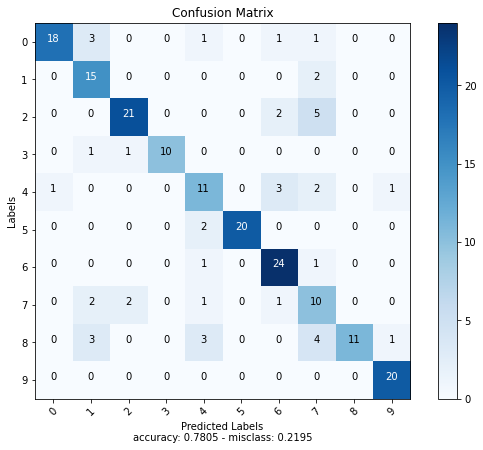

In [18]:
target_names=['0','1','2','3','4','5','6','7','8','9']
# plot_confusion_matrix(confusion_matrix, target_names, title='Confusion matrix', cmap=None, normalize=None)
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix).astype('float')
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = confusion_matrix.max() / 2
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(confusion_matrix[i, j]),
              horizontalalignment="center",
              color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Labels')
plt.xlabel('Predicted Labels\naccuracy: {:0.4f} - misclass: {:0.4f}'.format(accuracy, misclass))
plt.show()

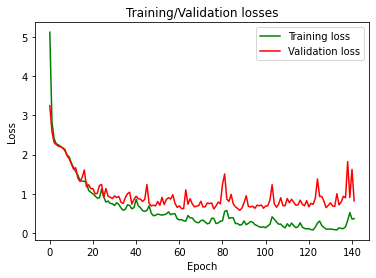

In [19]:
epochs = range(0,len(history.history['loss']))
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('Training/Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

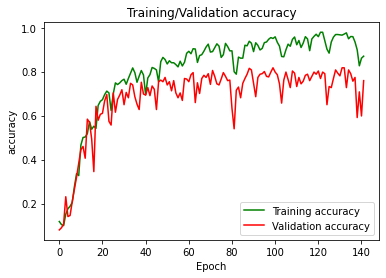

In [20]:
epochs = range(0,len(history.history['accuracy']))
acc_train = history.history['accuracy']
acc_val   = history.history['val_accuracy']
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'r', label='Validation accuracy')
plt.title('Training/Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()